<a href="https://colab.research.google.com/github/AyaElsawyElghaysh/HeadPoseDetection/blob/main/HeadPoseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow

In [ ]:
predictor=dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')
cnn_face_detector=dlib.get_frontal_face_detector()

In [ ]:
import os

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/AFLW2000-3D.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
FOLDER_PATH="/content/drive/MyDrive/PoseDetection"

In [ ]:
## extract all Mat & jpg 
all_jpg_img=[Path(f).stem for f in glob.glob(FOLDER_PATH+"/*.jpg")]
all_jpg_mat=[Path(f).stem for f in glob.glob(FOLDER_PATH+"/*.mat")]
exist_img = [ img for img in all_jpg_mat if img in all_jpg_img]

In [ ]:
len(all_jpg_img)

840

In [ ]:
len(exist_img)

840

In [ ]:
len(all_jpg_mat)

840

In [ ]:
# Extract 468-face-landMarks using mediapipe

def extract_land_marks(image_name):
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  x_list = []
  y_list = []
  
  image = cv2.imread(FOLDER_PATH +'/'+ image_name +'.jpg')

  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
  
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                x_list.append(x)
                y_list.append(y)
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
              
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        # cv2_imshow(image)
        
  return x_list, y_list

In [ ]:
#unit_test for the above function
image_name="image00002"
x_list,y_list=extract_land_marks(image_name,relative_path=image_name)

In [ ]:
len(x_list) #468 point

468

In [ ]:
# #append x_list & y-list to be the new features 
# def landmarks_df(image_name):
#   xlist,ylist=extract_land_marks(image_name)
#   df_xy=None
#   x=None
#   y=None
#   if len(xlist) !=0 or len(ylist)!=0:
#       row_image=np.concatenate((xlist,ylist))
#       row_image=row_image.reshape(1,2*468)
#       df_xy=pd.DataFrame(row_image)
      
#       return image_name,df_xy



In [ ]:
def reshaping(x, y):

  x=np.array(x)
  x=x.reshape(1,-1)

  y=np.array(y)
  y=y.reshape(1,-1)

  row = np.concatenate( (x, y), axis= 1)

  return row

In [ ]:
def build_featuresDF(all_jpg_img):
  all_data = []
  valid_img = []
  for img in all_jpg_img:

    x_list, y_list = extract_land_marks(img)
    # print(f"length of x= {len(x_list)},  length of y= {len(y_list)}")

    if (len(x_list) != 0) or ( len(y_list) != 0) :

      valid_img.append(img)

      row = reshaping(x_list, y_list)
  
      all_data.append(row)
      # print(row.shape)

  data = np.array(all_data, dtype= np.float32)

  data=data.reshape(-1,468*2)

  df = pd.DataFrame(data)
  # df.add(row , axis= 0)
  return df, valid_img
  

In [ ]:
df,valid_image=build_featuresDF(all_jpg_img)

In [ ]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(FOLDER_PATH +'/'+ mat_path +'.mat')
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    # And convert to degrees.
    pitch = pose_params[0] * 180 / np.pi
    yaw = pose_params[1] * 180 / np.pi
    roll = pose_params[2] * 180 / np.pi
    bins = np.array(range(-99, 102, 3))
    labels =np.digitize([pitch,yaw,roll], bins) - 1
    cont_labels = [pitch,yaw,roll]
    return cont_labels #roll, yaw, pitch

In [ ]:
get_ypr_from_mat("image00002")

[-22.874238643575588, 1.044306042017331, 4.908885557905314]

In [ ]:
def extract_labels(valid_img):
  all_labels = []
  for img in valid_img:
    cont_labels = get_ypr_from_mat(img)
    cont_labels = np.array(cont_labels, dtype=np.float32)
    cont_labels = cont_labels.reshape(1,-1)

    all_labels.append(cont_labels)

  data = np.array(all_labels, dtype= np.float32)

  data = data.reshape(-1,3)

  df = pd.DataFrame(data = data, columns= ["pitch","yaw","roll"])

  return df

In [ ]:
#all_jpg_img

In [ ]:
# #test above function on the whole DataFrame
# def dataFrameLandMarks(all_jpg_img):
#   df=None
#   valid_image=[]
#   for i in all_jpg_img:
#     #print(i)
#     image,landmark_df=landmarks_df(i)
   
#     valid_image.append(i)
#     df=pd.concat([df,landmark_df],axis=0)

#   return df,valid_image

In [ ]:
labelDF=extract_labels(valid_image)

In [ ]:
labelDF

,pitch,yaw,roll
0,19.859465,3.529330,-13.114094
1,-19.040035,-1.734840,-0.003748
2,8.759531,11.277360,40.998207
3,10.825566,-26.458492,-1.585853
4,0.214961,-2.499849,1.453955
...,...,...,...
798,2.322391,19.494829,-4.535991
799,-9.417717,-21.456425,1.561363
800,-9.503428,7.380381,-0.650560
801,-8.310953,8.060820,-15.099853


In [ ]:
labelDF.shape

(803, 3)

In [ ]:
labelDF.to_csv("ypr_label",index=False) #save to file
df2 = pd.read_csv("/content/ypr_label")
df2.head()

,pitch,yaw,roll
0,19.859465,3.529330,-13.114094
1,-19.040035,-1.734840,-0.003748
2,8.759531,11.277360,40.998207
3,10.825566,-26.458492,-1.585854
4,0.214961,-2.499849,1.453955


#save 468 point into csv file

In [ ]:
df.to_csv("data468points",index=False)
data=pd.read_csv("/content/data468points")

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.523277,0.505939,0.514365,0.480361,0.501990,0.498118,0.490049,0.357539,0.482229,0.476993,...,0.555605,0.547423,0.562231,0.556215,0.563540,0.482250,0.486530,0.487370,0.456441,0.445981
1,0.523301,0.521664,0.520384,0.500291,0.521270,0.519550,0.514295,0.363523,0.512216,0.511932,...,0.643948,0.636299,0.636401,0.647577,0.648883,0.484734,0.493071,0.500421,0.457532,0.451076
2,0.428060,0.462847,0.460043,0.504004,0.475886,0.498161,0.557878,0.470097,0.594398,0.610846,...,0.620462,0.622537,0.655452,0.618466,0.623118,0.549823,0.545117,0.542222,0.611641,0.615110
3,0.532379,0.550867,0.534962,0.527670,0.552143,0.547481,0.531225,0.394189,0.527122,0.528203,...,0.573452,0.568773,0.585973,0.573747,0.579145,0.499827,0.501065,0.500774,0.501750,0.495284
4,0.506423,0.511278,0.508846,0.498115,0.512179,0.512752,0.513709,0.380937,0.514855,0.515985,...,0.613908,0.608323,0.620817,0.615452,0.619419,0.501407,0.505033,0.507288,0.491784,0.485913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.479869,0.451849,0.472745,0.445637,0.448787,0.452500,0.468183,0.370129,0.469207,0.465482,...,0.613217,0.606111,0.614180,0.614969,0.619246,0.480625,0.486155,0.490317,0.458248,0.447682
799,0.539819,0.562152,0.542428,0.535207,0.564349,0.559282,0.539480,0.368779,0.534516,0.536501,...,0.622525,0.615883,0.627032,0.624668,0.628638,0.491575,0.497130,0.501123,0.477267,0.471925
800,0.492023,0.484100,0.491357,0.474483,0.483321,0.485438,0.493760,0.379530,0.496114,0.495448,...,0.619673,0.614233,0.620915,0.621776,0.624072,0.494327,0.499403,0.503776,0.482127,0.475065
801,0.521586,0.495252,0.507534,0.462877,0.488635,0.482593,0.471447,0.340014,0.460411,0.453129,...,0.616260,0.606680,0.606984,0.620060,0.622965,0.466255,0.475640,0.482309,0.430147,0.422762


In [ ]:
def draw_axis(image, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    img=cv2.imread(FOLDER_PATH +'/'+ image_name +'.jpg')
    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

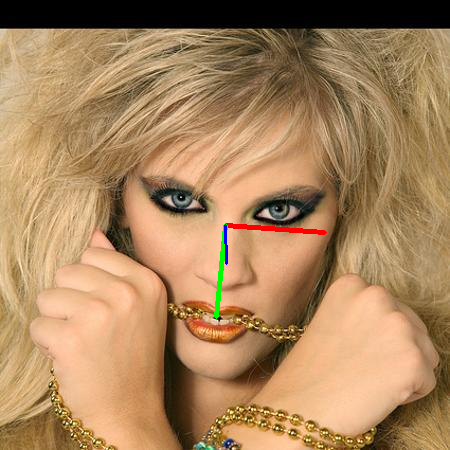

In [ ]:
#test unit
image="image00002"

pitch,yaw,roll=get_ypr_from_mat(image)
cv2_imshow(draw_axis(image, pitch,yaw,roll))

In [ ]:
def x(img, yaw, pitch, roll):
  # image = FOLDER_PATH +'/'+ img +'.jpg'
  frame = cv2.imread(img)
  cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  dets = cnn_face_detector(cv2_frame, 1)
  for (idx, det) in enumerate(dets):
              # Get x_min, y_min, x_max, y_max, conf
              x_min = det.left()
              y_min = det.top()
              x_max = det.right()-x_min
              y_max = det.bottom()-y_min
              # conf = det.confidence
              # print(det)

              shape = predictor(cv2_frame, det)
              tdx,tdy=shape.part(30).x, shape.part(30).y
              bbox_height, bbox_width = frame.shape[:2]
            
              cv2.destroyAllWindows()
              # cv2_imshow(draw_axis(img,-5.620685,-4.7939262 ,2.5846152,tdx,tdy)
              cv2_imshow(draw_axis(img,yaw, pitch , roll,tdx,tdy))
              
  cv2.destroyAllWindows()

preprocess

In [ ]:
X=data.iloc[:,:468]
Y=data.iloc[:,468:936]
Xpoints=np.array(X)
Ypoints=np.array(Y)
# center 99
# max = 10
# min = 171
# centering the data arround the 99th point 
Center_X = Xpoints - Xpoints[:,99].reshape(-1,1)
Center_Y = Ypoints - Ypoints[:,99].reshape(-1,1)
# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
X_171 = Xpoints[:,171]
X_10 = Xpoints[:,10]
Y_171 = Ypoints[:,171]
Y_10 = Ypoints[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features.shape)

(803, 468)
(803, 468)
(803, 936)


In [ ]:
features=pd.DataFrame(features)

In [ ]:
features

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.087793,0.045949,0.066285,-0.015783,0.036417,0.027074,0.007598,-0.312210,-0.011276,-0.023912,...,-0.064620,-0.084367,-0.048628,-0.063149,-0.045469,-0.241661,-0.231332,-0.229303,-0.303950,-0.329196
1,0.060336,0.057263,0.054858,0.017126,0.056523,0.053293,0.043425,-0.239718,0.039521,0.038987,...,-0.011499,-0.025863,-0.025671,-0.004685,-0.002232,-0.310495,-0.294838,-0.281036,-0.361579,-0.373703
2,-0.023072,0.043914,0.038515,0.123166,0.069022,0.111915,0.226907,0.057875,0.297229,0.328902,...,0.042345,0.046340,0.109722,0.038500,0.047459,-0.093678,-0.102740,-0.108316,0.025359,0.032038
3,0.053594,0.100161,0.060102,0.041735,0.103376,0.091632,0.050689,-0.294463,0.040354,0.043078,...,-0.022686,-0.034469,0.008851,-0.021942,-0.008346,-0.208125,-0.205007,-0.205739,-0.203281,-0.219567
4,0.040916,0.050863,0.045881,0.023894,0.052710,0.053884,0.055844,-0.216191,0.058191,0.060507,...,-0.013883,-0.025327,0.000273,-0.010720,-0.002593,-0.244385,-0.236955,-0.232335,-0.264102,-0.276130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.054590,0.000668,0.040880,-0.011287,-0.005225,0.001920,0.032101,-0.156599,0.034071,0.026903,...,-0.018284,-0.031961,-0.016431,-0.014913,-0.006682,-0.273453,-0.262809,-0.254800,-0.316517,-0.336850
799,0.045071,0.088260,0.050117,0.036151,0.092507,0.082709,0.044415,-0.285698,0.034816,0.038655,...,-0.019570,-0.032413,-0.010854,-0.015425,-0.007748,-0.272809,-0.262065,-0.254345,-0.300478,-0.310808
800,0.047378,0.030192,0.045933,0.009336,0.028504,0.033096,0.051146,-0.196611,0.056250,0.054807,...,-0.009634,-0.021433,-0.006940,-0.005073,-0.000093,-0.281499,-0.270489,-0.261006,-0.307961,-0.323277
801,0.088071,0.036135,0.060359,-0.027713,0.023086,0.011170,-0.010811,-0.270018,-0.032575,-0.046936,...,-0.036208,-0.055100,-0.054502,-0.028713,-0.022984,-0.332041,-0.313532,-0.300381,-0.403251,-0.417815


In [ ]:
#get labels

In [ ]:
df2.columns

Index(['pitch', 'yaw', 'roll'], dtype='object')

In [ ]:
pitch_label=df2['pitch']
roll_label=df2.roll
yaw_label=df2.yaw

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train,xtest,Y_train,ytest= train_test_split(features,df2,test_size = 0.2,random_state = 20)


In [ ]:
Y_train

,pitch,yaw,roll
211,4.629941,2.199407,5.165538
710,11.891141,21.201511,19.854633
225,-2.062296,-14.880998,-9.146642
191,1.217928,28.295897,22.666647
57,-5.831797,-15.282483,-3.431248
...,...,...,...
218,-7.534944,30.601194,-3.852012
223,-14.870719,-54.676044,11.755539
271,-5.892953,-27.881733,-15.286851
474,-75.027860,55.707153,-111.439670


In [ ]:
pitch_model = XGBRegressor(verbosity = 0)
yaw_model = XGBRegressor(verbosity = 0)
roll_model = XGBRegressor(verbosity = 0)

In [ ]:
gsc_pitch = GridSearchCV(
            estimator=pitch_model,
            param_grid={"estimator__learning_rate": (0.05, 0.10, 0.15)},
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result_pitch = gsc_pitch.fit(X_train, Y_train.pitch)
print(grid_result_pitch.best_params_)
print("Train Error: ",mean_absolute_error(grid_result_pitch.predict(X_train),Y_train.pitch))
print("Validation Error: ",mean_absolute_error(grid_result_pitch.predict(xtest),ytest.pitch))


{'estimator__learning_rate': 0.05}
Train Error:  2.1310135914109023
Validation Error:  6.846366050814738


In [ ]:
gsc_yaw = GridSearchCV(
            estimator=yaw_model,
            param_grid={"estimator__learning_rate": (0.05, 0.10, 0.15)},
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result_yaw = gsc_pitch.fit(X_train, Y_train.yaw)
print(grid_result_yaw.best_params_)
print("Train Error: ",mean_absolute_error(grid_result_yaw.predict(X_train),Y_train.yaw))
print("Validation Error: ",mean_absolute_error(grid_result_yaw.predict(xtest),ytest.yaw))


{'estimator__learning_rate': 0.05}
Train Error:  1.871277373956852
Validation Error:  4.3381494445206865


In [ ]:
gsc_roll = GridSearchCV(
            estimator=roll_model,
            param_grid={"estimator__learning_rate": (0.05, 0.10, 0.15)},
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result_roll= gsc_pitch.fit(X_train, Y_train.roll)
print(grid_result_roll.best_params_)
print("Train Error: ",mean_absolute_error(grid_result_roll.predict(X_train),Y_train.roll))
print("Validation Error: ",mean_absolute_error(grid_result_roll.predict(xtest),ytest.roll))

{'estimator__learning_rate': 0.05}
Train Error:  1.3419795288858598
Validation Error:  5.424971723995746


In [ ]:
# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode

# def take_photo(filename='photo.jpg', quality=0.8):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       // Wait for Capture to be clicked.
#       await new Promise((resolve) => capture.onclick = resolve);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)
#   data = eval_js('takePhoto({})'.format(quality))
#   binary = b64decode(data.split(',')[1])
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename

In [ ]:
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))
  
#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))

In [ ]:
# my_image="/content/photo.jpg"
# x_list,y_list=extract_land_marks(my_image,relative_path=None,abs_path=my_image)


In [ ]:
# row = reshaping(x_list, y_list)
# data=row.reshape(-1,468*2)
# df = pd.DataFrame(data)

In [ ]:
# df


In [ ]:
# pitch=grid_result_pitch.predict(X_train)
# yaw=grid_result_yaw.predict(X_train)
# roll=grid_result_yaw.predict(X_train)

In [ ]:
# x(my_image,yaw,pitch,roll)

In [ ]:
faceModule = mediapipe.solutions.face_mesh
def On_video(pitch_model,yaw_model,roll_model,size =20):
  cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/test.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  img_array = []
  while(cap.isOpened()):   
      ret, img = cap.read()
      if ret == True:

        with faceModule.FaceMesh(static_image_mode=True) as face:
          results = face.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                X = []
                Y = []
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                   
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = img.shape 
                    new_x = int(x * shape[1])
                    new_y = int(y * shape[0])
                        
                   
                    X.append(new_x)
                    Y.append(new_y)
                X = np.array(X)
                Y = np.array(Y)
                X_nose = X - X[99]
                Y_nose = Y - Y[99]
                Shortest_distance = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                X_normalized = X_nose/Shortest_distance
                Y_normalized = Y_nose/Shortest_distance
                features = np.hstack([X_normalized ,Y_normalized]).reshape(1,-1)
                features=pd.DataFrame(features)
                prediction_of_pitch = grid_result_pitch.predict(features)
                prediction_of_yaw = grid_result_yaw.predict(features)
                prediction_of_roll = grid_result_roll.predict(features)
                cv2_imshow(draw_axis(img,prediction_of_pitch,prediction_of_yaw,prediction_of_roll,X[1],Y[1]))
                img_array.append(img)
      else: 
          break
  cap.release()  
  cv2.destroyAllWindows()
  result = cv2.VideoWriter('video_result.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))
  for i in range(len(img_array)):
    result.write(img_array[i])
  result.release()
 

In [ ]:
On_video(grid_result_pitch,grid_result_yaw,grid_result_roll,size = 25)

In [ ]:
from google.colab import files
files.download('/content/video_result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>